import functions

In [1]:

import  os,warnings, sys, shutil, os, numpy as np, pandas as pd
# import pandas as pd


warnings.filterwarnings("ignore")
# import pickle
# import torch
from sklearn.metrics import  accuracy_score
path = os.path.dirname(os.getcwd())

data_path = path + '/.data/' 
sys.path.insert(0,data_path )
sys.path.insert(0,path + '/mutual_functions/' )


from evaluation_functions import *
from load_data import *
from normalization import *
from utils import *


# reload packages with new changes
%load_ext autoreload
%autoreload 2

# data_path
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
# torch.cuda.empty_cache()






In [2]:

prop = {'UCR':True,
        'dataset':'BasicMotions', #'shortTracks_seperate.pkl,LSST,AF,BasicMotions
        'data_path' : data_path,
        
        
        
        'norm':'MinMax01', #'MinMax01',MinMax-11 # 'mean_standardize', 'without_norm'
        'seq_len':20,#None, 
        'LEN':None, #None,#7
        'consecutive': True,

        'shuffle': False,
        'test_size' :0.2,
       

        'multivariate':True,
        # multivariate version for multivariate time series input: Multivariate compiles via Numba on import.
        'transform': 'MiniRocketMultivariate', #Rocket, 'MultiRocket','MiniRocket','MultiRocketMultivariate',  'MiniRocketMultivariate', 
        # RidgeClassifierCV for smaller datasets (<20k training examples). For larger datasets, use logistic regression trained with stochastic gradient descent SGDClassifier(loss='log'),
        # SGDClassifier: with loss="log" fits a logistic regression model, while with loss="hinge" fits a linear support vector machine (SVM).
        
        # sgd classifier check losses, change classifier kernel ridge polynimial, xgboost, random forest, 
        # feturee importance compare 
        #   
        # simple sklearn time series models

        'classifier': 'ridge', #'ridge','sgd-logistic','sgd-svm','sgd-perceptron', todo:'xgboost','random_forest'squared_hinge

        'val_size':0,
        'size_percentage' : None



        
}

In [3]:
# from usefull_functions import *
# from evaluation_functions import *

# X_train, y_train, X_test, y_test, prop=  load_data_sktime(prop,multivariate = True)
 
X_train,y_train,X_test,y_test,X_val,y_val,prop = loadData(prop,prop['data_path'])
X_train, X_test, X_val = normalizeData(X_train,X_test,X_val,norm  = prop['norm'])
X_train,X_test, X_val = convert_into_sktime(X_train),convert_into_sktime(X_test),convert_into_sktime(X_val)





Data loading start...
seq_len (n steps): 20, data columns: ['dim_0', 'dim_1', 'dim_2', 'dim_3', 'dim_4', 'dim_5']
train - 0: 810, test - 0: 810
train - 1: 810, test - 1: 810
train - 2: 810, test - 2: 810
train - 3: 810, test - 3: 810
preprocessing data using 'MinMax01' complete...
X_train: (3240, 20, 6), X_test: (3240, 20, 6), X_val: None


In [4]:
# Rocket

tfm = rocket_transform(X_train.copy(), transform_type = prop['transform'])#num_kernels=20000
X_train_transform,X_test_transform = tfm.transform(X_train.copy()),tfm.transform(X_test.copy())
print( f'transform dimensions: train - {X_train_transform.shape}, test - {X_test_transform.shape}')

MiniRocketMultivariate()
transform dimensions: train - (3240, 9996), test - (3240, 9996)


In [5]:


from sklearn.preprocessing import StandardScaler

# scaler seems to worsen the results
if prop['transform'] != 'Rocket':
    scaler = StandardScaler(with_mean=False)
    print(scaler.fit(X_train_transform.copy()))
    X_train_transform = scaler.transform(X_train_transform.copy())
    
else:
    scaler = None


classifier = rocket_classify(X_train_transform.copy(), y_train.copy(),cls =prop['classifier'])
y_test_pred = predict_cls( X_test_transform, y_test,classifier = classifier,scaler = scaler)



StandardScaler(with_mean=False)
RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]))
Test accuracy score of RidgeClassifierCV is 0.9185185185185185


inference & analysis
1. prediction of test data
2. returns test_metrics: for classification [loss, acc, prec, rec, f1] else [rmse, mae]

roc curve applicable only for binary classification (this is a multiclass classification)


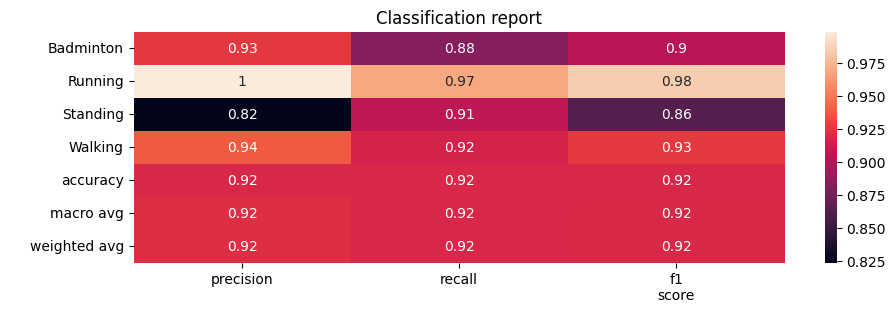

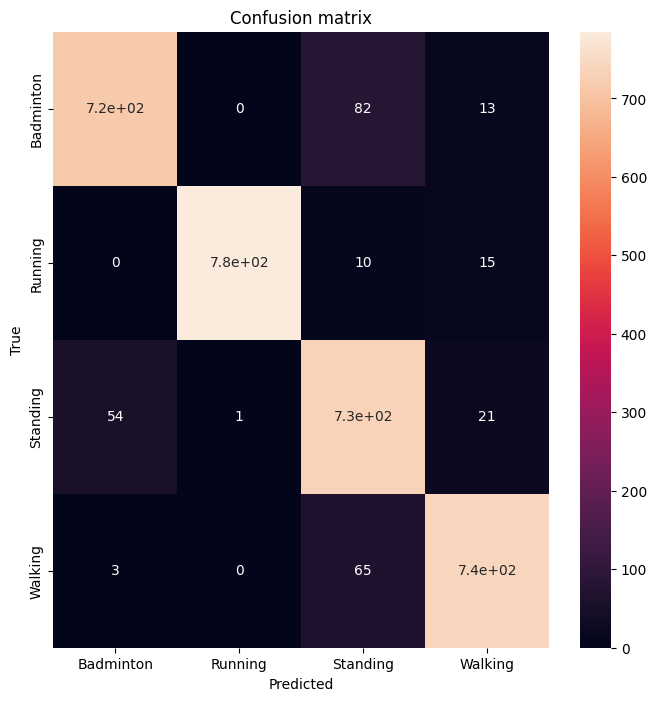

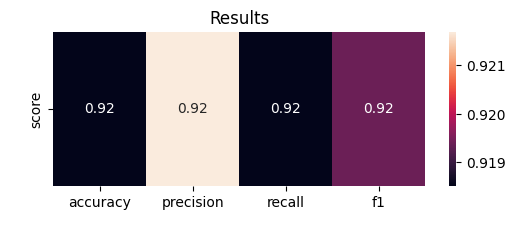

In [11]:



prop['class_names'],prop['class_transform'] = get_class_names(df=pd.read_csv(data_path + prop['dataset'] + '/class.csv', index_col=None),
                                                               class_to_consecutive = prop['class_to_consecutive'].copy(),type_ = 'type')

evaluate_(y_test_pred, y_test, prop['nclasses'],  class_names = prop['class_names'],class_transform = prop['class_transform'],
          model_name=prop['transform'] )#+ '_' + prop['classifier'])
